In [2]:
import numpy as np
import scipy
import quaternion as quat
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

%matplotlib inline

COLOR = 'k'#'#FFFAF1'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 14 #12
plt.rcParams['ytick.major.size']  = 14#12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 8
plt.rcParams['ytick.minor.size']  = 8

plt.rcParams

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'
from matplotlib.gridspec import GridSpec

In [4]:
def gr_indicator(chain, gr_threshold=1.01):
    chain = np.array(chain)
    (nsamp,nchain,ndim)=chain.shape   
    sw = np.mean(np.var(chain,axis=0),axis=0)   
    chainmean = np.mean(chain,axis=0)
    sv = (nsamp-1)/nsamp * sw + np.var(chainmean,axis=0)   
    RGR = sv/sw
    return(np.max(RGR)<gr_threshold)

def sqrtpdf(x,args):
    a=args
    x=np.array([x])
    y=1/np.sqrt(x)
    y[np.where(x<(1/a))]=0
    y[np.where(x>a)]=0
    return(y) 

def randDraw(pdf,args,a=100,b=None,dn=1):
    if b is None: b=a;a=-b
    assert(a<b)
    from scipy.integrate import quad
    from scipy.interpolate import interp1d
    import warnings
    import scipy

    warnings.simplefilter('ignore',scipy.integrate.IntegrationWarning) #ignores the rankwarnings from polyfit
    xsamp=np.arange(a,b,dn)
    A=1/quad(pdf,-np.infty,np.infty,args)[0]
    CDF=[]
    for x in xsamp:
        CDF.append(A*quad(pdf,-np.infty,x,args)[0])

    inverse=interp1d(CDF,xsamp)
    return(GenRand(inverse))

class GenRand:
    import numpy as np
    def __init__(self, inv):
        self.inv=inv      
    def __call__(self, size):
        x=np.random.uniform(size=int(size))
        return(self.inv(x))
    
def plot_2d_dist(x,y, xlim, ylim, nxbins, nybins, figsize=(5,5), 
                cmin=1.e-4, cmax=1.0, smooth=None, xpmax=None, ypmax=None, 
                log=False, weights=None, xlabel='x', ylabel='y', 
                clevs=None, fig_setup=None, savefig=None):
    """
    construct and plot a binned, 2d distribution in the x-y plane 
    using nxbins and nybins in x- and y- direction, respectively
 
    log = specifies whether logged quantities are passed to be plotted on log-scale outside this routine

    """
    from matplotlib.colors import LogNorm
    if fig_setup is None:
        fig, ax = plt.subplots(figsize=figsize)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.xlim(xlim[0], xlim[1])
        plt.ylim(ylim[0], ylim[1])

    else:
        ax = fig_setup
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xlim(xlim); ax.set_ylim(ylim)

    if xlim[1] < 0.: ax.invert_xaxis()
    if weights is None: weights = np.ones_like(x)

    H, xbins, ybins = np.histogram2d(x, y, weights=weights, bins=(np.linspace(xlim[0], xlim[1], nxbins),np.linspace(ylim[0], ylim[1], nybins)))

    H = np.rot90(H); H = np.flipud(H); 

    X,Y = np.meshgrid(xbins[:-1],ybins[:-1]) 
 
    if smooth != None:
        from scipy.signal import wiener
        H = wiener(H, mysize=smooth)

    H = H/np.sum(H)        
    Hmask = np.ma.masked_where(H==0,H)

    if log:
        X = np.power(10.,X); Y = np.power(10.,Y)

    pcol = ax.pcolormesh(X, Y,(Hmask),  cmap=plt.cm.BuPu, norm = LogNorm(), linewidth=0., rasterized=True)
    pcol.set_edgecolor('face')

    # plot contours if contour levels are specified in clevs 
    if clevs is not None:
        lvls = []
        for cld in clevs:  
            sig = opt.brentq( conf_interval, 0., 1., args=(H,cld) )   
            lvls.append(sig)
  
        ax.contour(X, Y, H, linewidths=(1.0,0.75, 0.5, 0.25), colors='black', levels = sorted(lvls), 
                norm = LogNorm(), extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]])
    
    if xpmax is not None:
        ax.scatter(xpmax, ypmax, marker='x', c='orangered', s=20)
    if savefig:
        plt.savefig(savefig,bbox_inches='tight')
    if fig_setup is None:
        plt.show()
    return

In [5]:
def evolving_axis_lightcurve(theta,phi,psi,a,b,c,alpha,beta,sun=[1,0,0]): 
    import warnings
    warnings.filterwarnings("ignore")
    
    if isinstance(theta, (np.floating, float)): theta=[theta]
    if isinstance(phi, (np.floating, float)): phi=[phi]
    if isinstance(psi, (np.floating, float)): psi=[psi]
    
    if len(beta.shape)==1:
        alpha=alpha[None,:]
        beta=beta[None,:]
    
    sun=quat.from_vector_part(sun)
    
    rot=np.array([np.cos(phi),np.sin(phi)*np.cos(psi),np.sin(phi)*np.sin(psi)]).T
    rot=np.einsum('ijk,ij->ijk',rot[:,None,:],beta)
    rot=quat.from_rotation_vector(rot)
    
    THETA,ALPHA=np.meshgrid(theta,alpha,indexing='ij')
    
    obs=np.array([np.cos(ALPHA),np.sin(ALPHA)*np.cos(THETA),np.sin(ALPHA)*np.sin(THETA)])
    obs=np.einsum('ijk->jki',obs)
    
    obs=quat.from_vector_part(obs)
    obs=quat.as_vector_part(rot*obs*rot.conj())
    
    sun=quat.as_vector_part(rot*sun*rot.conj())
    
    C=np.array([1/a**2,1/b**2,1/c**2])
    Ts=np.sqrt(np.einsum('ijk,ijk,k->ij',sun,sun,C))
    To=np.sqrt(np.einsum('ijk,ijk,k->ij',obs,obs,C))
    
    cosa=np.einsum('ijk,ijk,k->ij',sun,obs,C)/(Ts*To)
    cosa[np.where(cosa>1)]=1
    cosa[np.where(cosa<-1)]=-1
    
    aprime=np.arccos(cosa)
    
    aprime[np.isclose(aprime,0)]=0
    
    T=np.sqrt(np.abs(Ts**2+To**2+2*Ts*To*cosa))
    
    cosl=np.nan_to_num((Ts+To*cosa)/T,posinf=0,neginf=0)
    sinl=np.nan_to_num((To*np.sin(aprime))/T,posinf=0,neginf=0)

    lam=np.where(sinl>=0,np.arccos(cosl),-np.arccos(cosl)%(2*np.pi))
    lam[np.isclose(lam,0,atol=1e-6)]=0
    
    cotl=1/np.tan(lam/2)
    cotal=1/np.tan((aprime-lam)/2)
    
    L = np.where(np.sin(lam)!=0,sinl*np.sin(lam-aprime)*np.log(cotl*cotal),0)
    L += cosl+np.cos(lam-aprime)
    L[np.isclose(L,0)]=0
    L[L!=0] *= (np.pi*a*b*c*Ts*To/T)[L!=0]
    L[L==0] = 1e-15
    return(np.abs(L))

In [6]:
def MCMC(x0,nwalk=10,nminsteps=10**3,nmaxsteps=10**5,nconv=20,step=1,logfunc=None,
         args=None,convergence_func=None,conv_args=None):
    from numpy import matlib
    from tqdm.auto import tqdm
    x0 = np.array(x0)
    dims = np.size(x0)

    x = np.matlib.repmat(np.array(x0),nwalk,1)+np.random.normal(0,0.01,(nwalk,dims))
    fnow = logfunc(x,args)
 
    chain = []
    nsteps = 0
    converged = False
    print_val = True
    sqrt_dist=randDraw(sqrtpdf,2,a=0,b=2.01,dn=0.01)
    
    pbar=tqdm(total=nmaxsteps)
    while not converged or (nsteps < nminsteps):
        rand = np.random.randint(1,nwalk,size=nwalk)
        j = (np.arange(nwalk)+rand)%nwalk
        xj = x[j]
        z = step*sqrt_dist(nwalk)       

        xtry = xj+np.multiply(np.matlib.repmat(z,dims,1).T,(x-xj))
        ftry = logfunc(xtry,args)
 
        logp = (dims-1)*np.log(z)+ftry-fnow
        prob = np.matlib.repmat(logp,dims,1).T
        rand = np.matlib.repmat(np.log(np.random.uniform(size=nwalk)),dims,1).T       

        x = np.where(rand<=prob,xtry,x)
        chain.append(x)
        fnow = logfunc(x,args)
       
        nsteps += 1
        if nsteps%nconv == 0: 
            pbar.update(20)
            converged = convergence_func(chain,conv_args)
        if converged and print_val:
            print("Converged at N = %s"%nsteps)
            print_val = False
        if nsteps > nmaxsteps: break
        
    pbar.close()
    return(np.reshape(chain,[-1,dims]))

In [7]:
def lnL(x,y,sigy):
    vary=sigy**2
    L=-0.5*(np.sum((x-y)**2/vary,axis=-1)+2*np.pi*np.sum(vary))
    return(L)

def min_wrapper(x,p,theta,phi,psi,mag,sigmag,alpha,beta,a,b,c):
    deltaV=x[0]
    betainit=x[1]

    sim=deltaV-2.5*np.log10(evolving_axis_lightcurve(theta,phi,psi,a,b,c,alpha,beta))

    return(-1*lnL(sim,mag,sigmag))

def lnprior(params,bounds):
    '''
    Params is an array of (n,ndims) shape. 
    Bounds is a list of (min,max) tuples
    
    Returns (n,) array of ln(prior) outputs
    
    '''
    bounds=np.array(bounds)
    
    out=np.zeros(params.shape[0])
    
    out+=np.where(np.any(params<bounds[:,0],axis=-1),-1e300,0)
    out+=np.where(np.any(params>bounds[:,1],axis=-1),-1e300,0)
    
    return(out)
        
def MCMCwrapper(x,args):
    from scipy.optimize import minimize
    period=x[:,0]/24
    #theta=x[:,1]
    phi=x[:,1]
    psi=x[:,2]
    
    mag,sigmag,alpha,time,a,b,c,bounds,deltaV,betainit=args
    
    PER,TIME=np.meshgrid(period,time,indexing='ij')
    beta=2*np.pi*(TIME%PER)/PER
    
    simprior=lnprior(x,bounds)
    
    inds=np.where(simprior>=0)[0]
    
    curves=np.zeros((period.size,time.size))
    
    LML=evolving_axis_lightcurve(theta[inds],phi[inds],psi[inds],a,b,c,alpha,beta[inds,:]-betainit)
    
    curves[inds,:]=deltaV-2.5*np.log10(LML)
        
    return(lnL(curves,mag,sigmag)+simprior)

In [8]:
plotA=np.genfromtxt('../Lightcurves/Photometry/plotA.csv',comments='#', delimiter=',' )
plotB=np.genfromtxt('../Lightcurves/Photometry/plotB.csv',comments='#', delimiter=',' )
plotC=np.genfromtxt('../Lightcurves/Photometry/plotC.csv',comments='#', delimiter=',' )
plotD=np.genfromtxt('../Lightcurves/Photometry/plotD.csv',comments='#', delimiter=',' )
plotE=np.genfromtxt('../Lightcurves/Photometry/plotE.csv',comments='#', delimiter=',' )
plotF=np.genfromtxt('../Lightcurves/Photometry/plotF.csv',comments='#', delimiter=',' )
plotG=np.genfromtxt('../Lightcurves/Photometry/plotG.csv',comments='#', delimiter=',' )
plotH=np.genfromtxt('../Lightcurves/Photometry/plotH.csv',comments='#', delimiter=',' )
plotI=np.genfromtxt('../Lightcurves/Photometry/plotI.csv',comments='#', delimiter=',' )

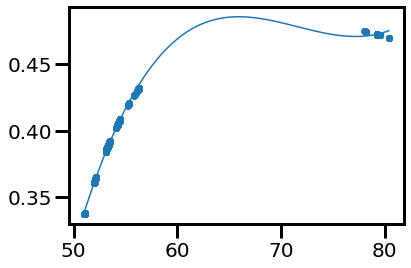

In [53]:
from scipy.interpolate import UnivariateSpline

belton=pd.read_csv("../Lightcurves/Photometry/1I_2017U1_lightcurve.csv")

beltime=belton['corrMMJD'].to_numpy()
belmag=belton['corrm'].to_numpy()
belsig=belton['sigma'].to_numpy()
belalpha=belton['aPh'].to_numpy()*np.pi/180

belton=np.array([beltime,belmag,belsig]).T

nbeltime=beltime[beltime<55.5]
nbelmag=belmag[beltime<55.5]
nbelsig=belsig[beltime<55.5]
nbelalpha=belalpha[beltime<55.5]

alpha=UnivariateSpline(beltime[np.argsort(beltime)],belalpha[np.argsort(beltime)],s=100)

times=np.linspace(np.min(beltime),np.max(beltime),1000)
plt.plot(times,alpha(times))
plt.scatter(beltime,belalpha)
plt.show()

In [93]:
x0=np.array([7.32,1,0])
bounds=[(5,9),(0,np.pi/2),(-np.pi/2,np.pi/2)]
args=(nbelmag,nbelsig,nbelalpha,nbeltime-np.min(nbeltime),19,115,111,bounds,33.25,np.pi/2)
chain=MCMC(x0,nwalk=10,nminsteps=10**3,nmaxsteps=10**5,nconv=20,step=1,logfunc=MCMCwrapper,
         args=args,convergence_func=gr_indicator,conv_args=1.01)

  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [86]:
opt=np.median(chain,axis=0)
opt[0]*=1/24

print(np.median(chain,axis=0))
print(np.mean(chain,axis=0))
print(np.max(chain,axis=0))
print(np.min(chain,axis=0))

[ 6.58925691  1.31666846 -0.12717654]
[6.7080324  1.14262763 0.09010497]
[7.55085523 1.55084496 1.56904699]
[ 5.07721275  0.35764466 -1.28193226]


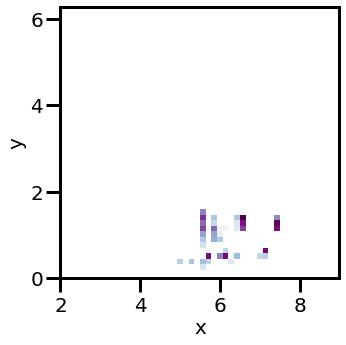

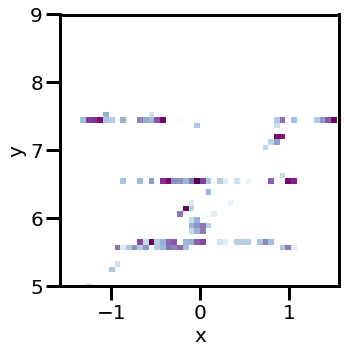

In [87]:
plot_2d_dist(chain[:,0],chain[:,1],xlim=[2,9],ylim=[0,2*np.pi],nxbins=50,nybins=50)
plot_2d_dist(chain[:,2],chain[:,0],xlim=[-np.pi/2,np.pi/2],ylim=[5,9],nxbins=50,nybins=50)

In [88]:
beta=2*np.pi*((beltime-np.min(beltime))%opt[0])/opt[0]-np.pi/2

curve=33.25-2.5*np.log10(evolving_axis_lightcurve(0,opt[1],opt[2],a,b,c,belalpha,beta))

print(lnL(curve,belmag,belsig))

[-62231.1479604]


In [89]:
a,b,c=19,115,111
times=np.linspace(np.min(beltime)-0.1,np.max(beltime)+0.1,10000)
p=opt[0]
beta=2*np.pi*((times-np.min(times))%p)/p-np.pi/2

curve=33.25-2.5*np.log10(evolving_axis_lightcurve(0,opt[1],opt[2],a,b,c,alpha(times),beta))[0,:]

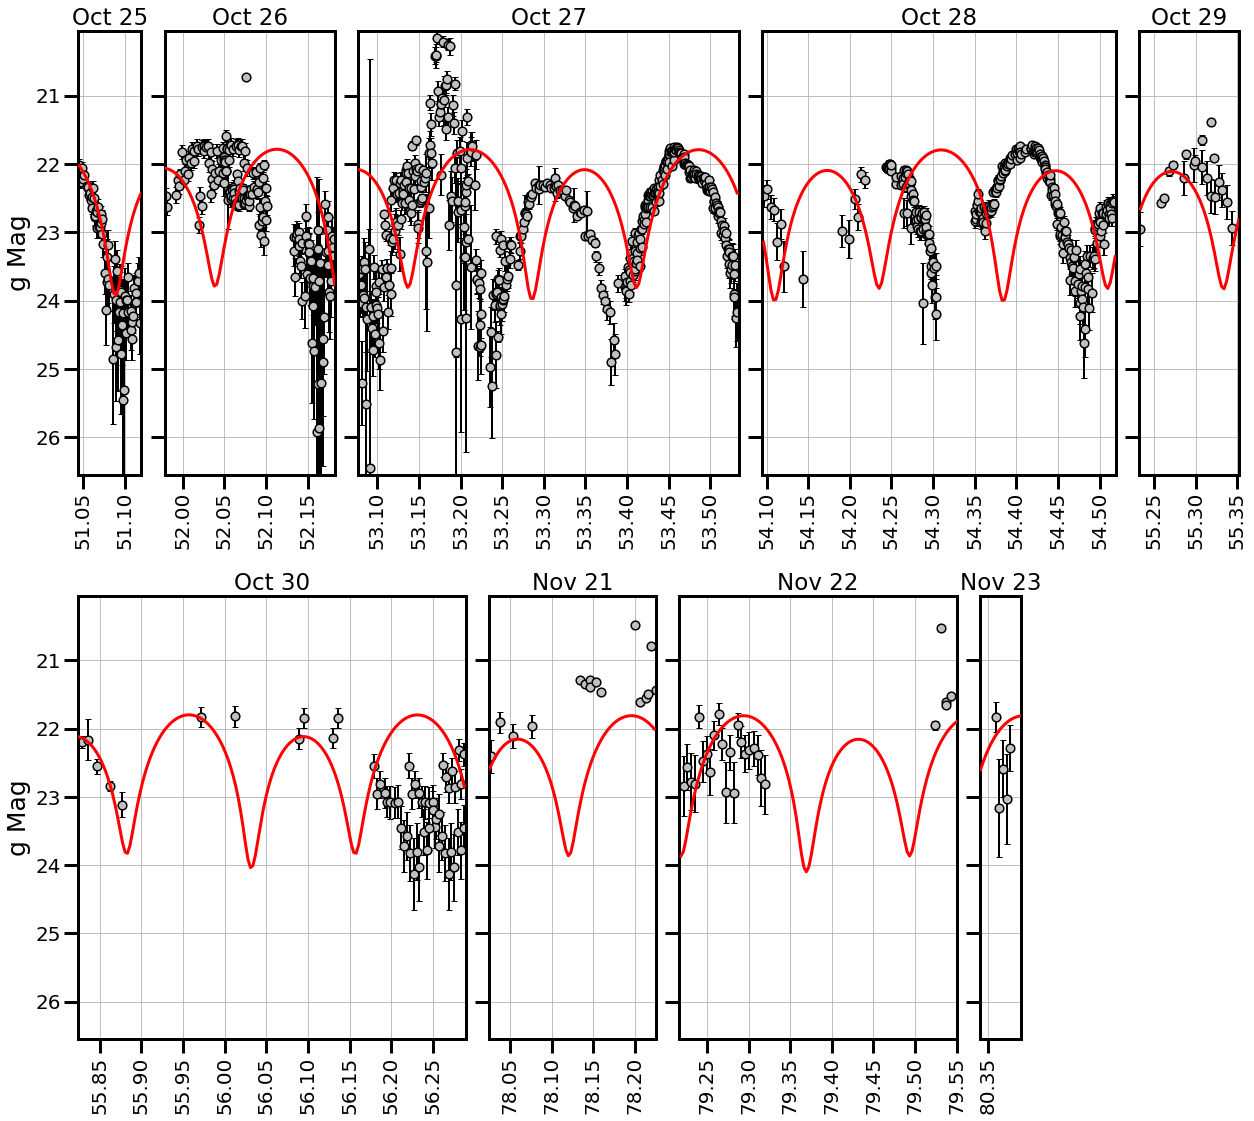

In [90]:
import matplotlib.ticker as ticker

figx,figy=16,14
fig = plt.figure(figsize=(figx,figy))
ymin,ymax=np.min(belton[:,1])-0.1,np.max(belton[:,1])+0.1

axspace=0.02
tickspace=0.05

yspace=0.06

totalwidth=5*axspace+plotA[-1,0]-plotA[0,0]+plotB[-1,0]-plotB[0,0]+plotC[-1,0]-plotC[0,0]+\
            plotD[-1,0]-plotD[0,0]+plotE[-1,0]-plotE[0,0]#+plotF[-1,0]-plotF[0,0]
platescale=1/totalwidth

corner=0

axes=[]

xmin,xmax=plotA[0,0], plotA[-1,0]
dx = (xmax-xmin)*platescale
ax=fig.add_axes([corner,0.5+yspace,dx,0.5-yspace])
axes.append(ax)
ax.set_xlim([xmin,xmax])
ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
ax.set_title('Oct 25',fontsize=23)
ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
              fmt='none',ecolor='k',elinewidth=2,capsize=3)
ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
ax.plot(times[np.where((times<xmax)&(times>xmin))],
             curve[np.where((times<xmax)&(times>xmin))],
             color='r',zorder=3,lw=3)
ax.set_ylabel("g Mag",fontsize=25)
plt.xticks(rotation=90)
corner+=dx+axspace

xmin,xmax=plotB[0,0], plotB[-1,0]
dx = (xmax-xmin)*platescale
ax=fig.add_axes([corner,0.5+yspace,dx,0.5-yspace])
axes.append(ax)
ax.set_xlim([xmin,xmax])
ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
ax.set_title('Oct 26',fontsize=23)
ax.set_yticklabels([])
ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
              fmt='none',ecolor='k',elinewidth=2,capsize=3)
ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
ax.plot(times[np.where((times<xmax)&(times>xmin))],
             curve[np.where((times<xmax)&(times>xmin))],
             color='r',zorder=3,lw=3)
plt.xticks(rotation=90)
corner+=dx+axspace

xmin,xmax=plotC[0,0], plotC[-1,0]
dx = (xmax-xmin)*platescale
ax=fig.add_axes([corner,0.5+yspace,dx,0.5-yspace])
axes.append(ax)
ax.set_xlim([xmin,xmax])
ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
ax.set_title('Oct 27',fontsize=23)
ax.set_yticklabels([])
ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
              fmt='none',ecolor='k',elinewidth=2,capsize=3)
ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
ax.plot(times[np.where((times<xmax)&(times>xmin))],
             curve[np.where((times<xmax)&(times>xmin))],
             color='r',zorder=3,lw=3)
plt.xticks(rotation=90)
corner+=dx+axspace

xmin,xmax=plotD[0,0], plotD[-1,0]
dx = (xmax-xmin)*platescale
ax=fig.add_axes([corner,0.5+yspace,dx,0.5-yspace])
axes.append(ax)
ax.set_xlim([xmin,xmax])
ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
ax.set_title('Oct 28',fontsize=23)
ax.set_yticklabels([])
ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
              fmt='none',ecolor='k',elinewidth=2,capsize=3)
ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
ax.plot(times[np.where((times<xmax)&(times>xmin))],
             curve[np.where((times<xmax)&(times>xmin))],
             color='r',zorder=3,lw=3)
plt.xticks(rotation=90)
corner+=dx+axspace

xmin,xmax=plotE[0,0], plotE[-1,0]
dx = (xmax-xmin)*platescale
ax=fig.add_axes([corner,0.5+yspace,dx,0.5-yspace])
axes.append(ax)
ax.set_xlim([xmin,xmax])
ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
ax.set_title('Oct 29',fontsize=23)
ax.set_yticklabels([])
ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
              fmt='none',ecolor='k',elinewidth=2,capsize=3)
ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
ax.plot(times[np.where((times<xmax)&(times>xmin))],
             curve[np.where((times<xmax)&(times>xmin))],
             color='r',zorder=3,lw=3)
plt.xticks(rotation=90)
corner+=dx+axspace


corner=0

xmin,xmax=plotF[0,0], plotF[-1,0]
dx = (xmax-xmin)*platescale
ax=fig.add_axes([corner,0,dx,0.5-yspace])
axes.append(ax)
ax.set_xlim([xmin,xmax])
ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
ax.set_title('Oct 30',fontsize=23)
ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
              fmt='none',ecolor='k',elinewidth=2,capsize=3)
ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
ax.plot(times[np.where((times<xmax)&(times>xmin))],
             curve[np.where((times<xmax)&(times>xmin))],
             color='r',zorder=3,lw=3)
plt.xticks(rotation=90)
ax.set_ylabel("g Mag",fontsize=25)
corner+=dx+axspace

xmin,xmax=plotG[0,0], plotG[-1,0]
dx = (xmax-xmin)*platescale
ax=fig.add_axes([corner,0,dx,0.5-yspace])
axes.append(ax)
ax.set_xlim([xmin,xmax])
ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
ax.set_title('Nov 21',fontsize=23)
ax.set_yticklabels([])
ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
              fmt='none',ecolor='k',elinewidth=2,capsize=3)
ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
ax.plot(times[np.where((times<xmax)&(times>xmin))],
             curve[np.where((times<xmax)&(times>xmin))],
             color='r',zorder=3,lw=3)
plt.xticks(rotation=90)
corner+=dx+axspace

xmin,xmax=plotH[0,0], plotH[-1,0]
dx = (xmax-xmin)*platescale
ax=fig.add_axes([corner,0,dx,0.5-yspace])
axes.append(ax)
ax.set_xlim([xmin,xmax])
ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
ax.set_title('Nov 22',fontsize=23)
ax.set_yticklabels([])
ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
              fmt='none',ecolor='k',elinewidth=2,capsize=3)
ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
ax.plot(times[np.where((times<xmax)&(times>xmin))],
             curve[np.where((times<xmax)&(times>xmin))],
             color='r',zorder=3,lw=3)
plt.xticks(rotation=90)
corner+=dx+axspace

xmin,xmax=80.34,80.39
dx = (xmax-xmin)*platescale
ax=fig.add_axes([corner,0,dx,0.5-yspace])
axes.append(ax)
ax.set_xlim([xmin,xmax])
ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
ax.set_title('Nov 23',fontsize=23)
ax.set_yticklabels([])
ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
              fmt='none',ecolor='k',elinewidth=2,capsize=3)
ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
ax.plot(times[np.where((times<xmax)&(times>xmin))],
             curve[np.where((times<xmax)&(times>xmin))],
             color='r',zorder=3,lw=3)
plt.xticks(rotation=90)
corner+=dx+axspace

for ax in axes:
    ax.grid()
    ax.set_ylim([ymax,ymin])
    
plt.savefig('fixed_axis_lightcurve.pdf',
           bbox_inches='tight',dpi=300)


In [22]:
def gridwrapper(x,args):
    from scipy.optimize import minimize
    period=x[:,0]/24
    theta=x[:,1]
    phi=x[:,2]
    psi=x[:,3]+theta
    betainit=x[:,4]
    
    mag,sigmag,alpha,time,a,b,c,deltaV=args
    
    PER,TIME=np.meshgrid(period,time,indexing='ij')
    beta=2*np.pi*(TIME%PER)/PER
    
    BETAI,PER=np.meshgrid(betainit,time,indexing='ij')
    
    curves=np.zeros((period.size,time.size))
    
    LML=evolving_axis_lightcurve(theta,phi,psi,a,b,c,alpha,beta-BETAI)
    
    curves=deltaV-2.5*np.log10(LML)
        
    return(lnL(curves,mag,sigmag))

In [91]:
period=np.linspace(5,9,10)
theta=np.linspace(0,2*np.pi,10)
phi=np.linspace(0,np.pi/2,10)
deltpsi=np.linspace(-np.pi/2,np.pi/2,10)
betainit=np.linspace(np.pi/2,np.pi/2,10)

PER,THET,PHI,DPSI,BETAI=np.meshgrid(period,theta,phi,deltpsi,betainit,indexing='ij')

per=PER.flatten()
thet=THET.flatten()
phi=PHI.flatten()
dpsi=DPSI.flatten()
betai=BETAI.flatten()

x=np.array([per,thet,phi,dpsi,betai]).T
args=(nbelmag,nbelsig,nbelalpha,nbeltime-np.min(nbeltime),19,115,111,33.25)
res=gridwrapper(x,args)

In [94]:
ind=np.argmax(res)
print(per[ind])
print(thet[ind])
print(phi[ind])
print(dpsi[ind])
print(betai[ind])

7.222222222222222
4.1887902047863905
0.6981317007977318
0.5235987755982987
1.5707963267948966


In [99]:
a,b,c=19,115,111
times=np.linspace(np.min(beltime)-0.1,np.max(beltime)+0.1,10000)
p=per[ind]/24
beta=2*np.pi*((times-np.min(times))%p)/p-betai[ind]

curve=33.25-2.5*np.log10(evolving_axis_lightcurve(np.pi/2,phi[ind],dpsi[ind]+thet[ind],a,b,c,alpha(times),beta))[0,:]

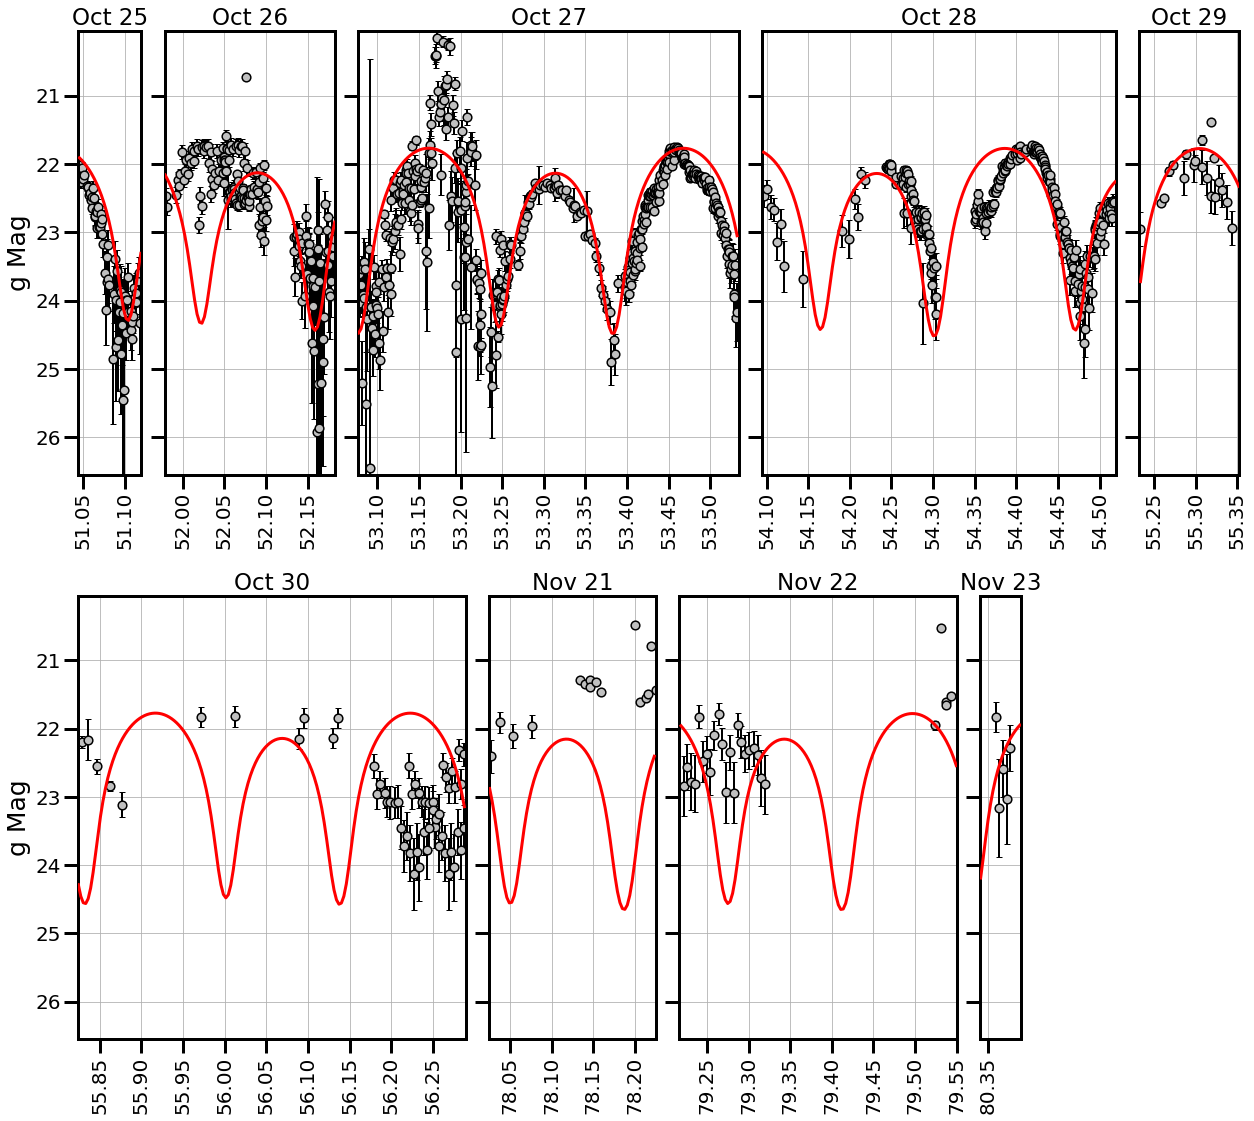

In [468]:
import matplotlib.ticker as ticker

figx,figy=16,14
fig = plt.figure(figsize=(figx,figy))
ymin,ymax=np.min(belton[:,1])-0.1,np.max(belton[:,1])+0.1

axspace=0.02
tickspace=0.05

yspace=0.06

totalwidth=5*axspace+plotA[-1,0]-plotA[0,0]+plotB[-1,0]-plotB[0,0]+plotC[-1,0]-plotC[0,0]+\
            plotD[-1,0]-plotD[0,0]+plotE[-1,0]-plotE[0,0]#+plotF[-1,0]-plotF[0,0]
platescale=1/totalwidth

corner=0

axes=[]

xmin,xmax=plotA[0,0], plotA[-1,0]
dx = (xmax-xmin)*platescale
ax=fig.add_axes([corner,0.5+yspace,dx,0.5-yspace])
axes.append(ax)
ax.set_xlim([xmin,xmax])
ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
ax.set_title('Oct 25',fontsize=23)
ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
              fmt='none',ecolor='k',elinewidth=2,capsize=3)
ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
ax.plot(times[np.where((times<xmax)&(times>xmin))],
             curve[np.where((times<xmax)&(times>xmin))],
             color='r',zorder=3,lw=3)
ax.set_ylabel("g Mag",fontsize=25)
plt.xticks(rotation=90)
corner+=dx+axspace

xmin,xmax=plotB[0,0], plotB[-1,0]
dx = (xmax-xmin)*platescale
ax=fig.add_axes([corner,0.5+yspace,dx,0.5-yspace])
axes.append(ax)
ax.set_xlim([xmin,xmax])
ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
ax.set_title('Oct 26',fontsize=23)
ax.set_yticklabels([])
ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
              fmt='none',ecolor='k',elinewidth=2,capsize=3)
ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
ax.plot(times[np.where((times<xmax)&(times>xmin))],
             curve[np.where((times<xmax)&(times>xmin))],
             color='r',zorder=3,lw=3)
plt.xticks(rotation=90)
corner+=dx+axspace

xmin,xmax=plotC[0,0], plotC[-1,0]
dx = (xmax-xmin)*platescale
ax=fig.add_axes([corner,0.5+yspace,dx,0.5-yspace])
axes.append(ax)
ax.set_xlim([xmin,xmax])
ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
ax.set_title('Oct 27',fontsize=23)
ax.set_yticklabels([])
ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
              fmt='none',ecolor='k',elinewidth=2,capsize=3)
ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
ax.plot(times[np.where((times<xmax)&(times>xmin))],
             curve[np.where((times<xmax)&(times>xmin))],
             color='r',zorder=3,lw=3)
plt.xticks(rotation=90)
corner+=dx+axspace

xmin,xmax=plotD[0,0], plotD[-1,0]
dx = (xmax-xmin)*platescale
ax=fig.add_axes([corner,0.5+yspace,dx,0.5-yspace])
axes.append(ax)
ax.set_xlim([xmin,xmax])
ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
ax.set_title('Oct 28',fontsize=23)
ax.set_yticklabels([])
ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
              fmt='none',ecolor='k',elinewidth=2,capsize=3)
ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
ax.plot(times[np.where((times<xmax)&(times>xmin))],
             curve[np.where((times<xmax)&(times>xmin))],
             color='r',zorder=3,lw=3)
plt.xticks(rotation=90)
corner+=dx+axspace

xmin,xmax=plotE[0,0], plotE[-1,0]
dx = (xmax-xmin)*platescale
ax=fig.add_axes([corner,0.5+yspace,dx,0.5-yspace])
axes.append(ax)
ax.set_xlim([xmin,xmax])
ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
ax.set_title('Oct 29',fontsize=23)
ax.set_yticklabels([])
ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
              fmt='none',ecolor='k',elinewidth=2,capsize=3)
ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
ax.plot(times[np.where((times<xmax)&(times>xmin))],
             curve[np.where((times<xmax)&(times>xmin))],
             color='r',zorder=3,lw=3)
plt.xticks(rotation=90)
corner+=dx+axspace


corner=0

xmin,xmax=plotF[0,0], plotF[-1,0]
dx = (xmax-xmin)*platescale
ax=fig.add_axes([corner,0,dx,0.5-yspace])
axes.append(ax)
ax.set_xlim([xmin,xmax])
ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
ax.set_title('Oct 30',fontsize=23)
ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
              fmt='none',ecolor='k',elinewidth=2,capsize=3)
ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
ax.plot(times[np.where((times<xmax)&(times>xmin))],
             curve[np.where((times<xmax)&(times>xmin))],
             color='r',zorder=3,lw=3)
plt.xticks(rotation=90)
ax.set_ylabel("g Mag",fontsize=25)
corner+=dx+axspace

xmin,xmax=plotG[0,0], plotG[-1,0]
dx = (xmax-xmin)*platescale
ax=fig.add_axes([corner,0,dx,0.5-yspace])
axes.append(ax)
ax.set_xlim([xmin,xmax])
ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
ax.set_title('Nov 21',fontsize=23)
ax.set_yticklabels([])
ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
              fmt='none',ecolor='k',elinewidth=2,capsize=3)
ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
ax.plot(times[np.where((times<xmax)&(times>xmin))],
             curve[np.where((times<xmax)&(times>xmin))],
             color='r',zorder=3,lw=3)
plt.xticks(rotation=90)
corner+=dx+axspace

xmin,xmax=plotH[0,0], plotH[-1,0]
dx = (xmax-xmin)*platescale
ax=fig.add_axes([corner,0,dx,0.5-yspace])
axes.append(ax)
ax.set_xlim([xmin,xmax])
ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
ax.set_title('Nov 22',fontsize=23)
ax.set_yticklabels([])
ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
              fmt='none',ecolor='k',elinewidth=2,capsize=3)
ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
ax.plot(times[np.where((times<xmax)&(times>xmin))],
             curve[np.where((times<xmax)&(times>xmin))],
             color='r',zorder=3,lw=3)
plt.xticks(rotation=90)
corner+=dx+axspace

xmin,xmax=80.34,80.39
dx = (xmax-xmin)*platescale
ax=fig.add_axes([corner,0,dx,0.5-yspace])
axes.append(ax)
ax.set_xlim([xmin,xmax])
ax.xaxis.set_major_locator(ticker.MultipleLocator(tickspace))
ax.set_title('Nov 23',fontsize=23)
ax.set_yticklabels([])
ax.errorbar(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              yerr=belton[:,2][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))], 
              fmt='none',ecolor='k',elinewidth=2,capsize=3)
ax.scatter(belton[:,0][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              belton[:,1][np.where((belton[:,0]<xmax)&(belton[:,0]>xmin))],
              s=75,edgecolors='k', linewidths=1.5,marker='o',color='silver',label='NOT',zorder=2)
ax.plot(times[np.where((times<xmax)&(times>xmin))],
             curve[np.where((times<xmax)&(times>xmin))],
             color='r',zorder=3,lw=3)
plt.xticks(rotation=90)
corner+=dx+axspace

for ax in axes:
    ax.grid()
    ax.set_ylim([ymax,ymin])
    
plt.savefig('evolving_axis_lightcurve.pdf',
           bbox_inches='tight',dpi=300)

In [453]:
def Hfunction(time,p,phi,psi,betainit):
    p=p/24
    beta=2*np.pi*((time-np.min(time))%p)/p-betainit
    curve=33.25-2.5*np.log10(evolving_axis_lightcurve(0,phi,psi,19,115,111,alpha(time),beta))[0,:]
    
    return(curve)

def chi2(x,y,sy):
    return(np.sum(np.square(x-y)/sy**2))

In [467]:
curve=Hfunction(times,7.35,1.2,1.3,1.7)

In [455]:
curve=Hfunction(times,6.969,1.353,1.57,4.674)

In [458]:
from scipy.optimize import curve_fit

popt,_=curve_fit(Hfunction,nbeltime,nbelmag,p0=[7.35,1.2,1.3,np.pi/2],
                    sigma=nbelsig,absolute_sigma=True,
                    bounds=([5,0,-np.pi/2,-np.pi],[10,np.pi/2,np.pi/2,np.pi]),maxfev=5000)
print(popt)
curve=Hfunction(times,*popt)

[7.19489172 1.41915858 1.57079633 3.14159265]


In [460]:
print(chi2(Hfunction(nbeltime,*popt),nbelmag,nbelsig))
print(chi2(Hfunction(nbeltime,7.35,1.2,1.3,1.7),nbelmag,nbelsig))

213082.34696028088
335684.5645906952


In [464]:
print(np.max(nbeltime))

55.354
